In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
class AntColony:
    def __init__(self, distances, city_names, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        # distances: Mảng 2 chiều chứa khoảng cách giữa các thành phố
        self.distances = distances

        # city_names: Danh sách tên các thành phố tương ứng với chỉ số trong mảng distances
        self.city_names = city_names

        # pheromone: Khởi tạo mảng pheromone với mỗi giá trị ban đầu bằng 1 chia cho số lượng thành phố
        self.pheromone = np.ones(self.distances.shape) / len(distances)

        # all_inds: Dãy chỉ số từ 0 đến số lượng thành phố, dùng để truy cập vào các thành phố trong mảng
        self.all_inds = range(len(distances))

        # n_ants: Số lượng kiến sử dụng trong mô hình
        self.n_ants = n_ants

        # n_best: Số lượng đường đi tốt nhất để cập nhật pheromone
        self.n_best = n_best

        # n_iterations: Số lần lặp (thế hệ) thuật toán sẽ chạy
        self.n_iterations = n_iterations

        # decay: Tỷ lệ bay hơi pheromone sau mỗi lần lặp
        self.decay = decay

        # alpha: Hệ số ảnh hưởng của pheromone đến xác suất chọn lộ trình (tương quan với tầm quan trọng của pheromone)
        self.alpha = alpha

        # beta: Hệ số ảnh hưởng của heuristic (nghịch đảo khoảng cách) đến xác suất chọn lộ trình
        self.beta = beta



    def spread_pheromone(self, all_paths, n_best, shortest_path):
        # Sắp xếp tất cả các đường đi dựa trên độ dài (khoảng cách) của chúng
        sorted_paths = sorted(all_paths, key=lambda x: x[1])

        # Lặp qua n_best đường đi ngắn nhất để tăng cường pheromone
        for path, dist in sorted_paths[:n_best]:
            # Tăng cường pheromone trên mỗi bước di chuyển trong đường đi
            for move in path:
                # Cập nhật lượng pheromone trên từng đoạn đường dựa vào độ dài đoạn đường đó
                # Bằng cách lấy nghịch đảo của khoảng cách: pheromone càng cao khi khoảng cách càng ngắn
                self.pheromone[move] += 1.0 / self.distances[move]


    def gen_all_paths(self):
        # Khởi tạo một danh sách rỗng để lưu trữ tất cả các đường đi được sinh ra
        all_paths = []

        # Lặp qua số lượng kiến đã được định trước (n_ants)
        for i in range(self.n_ants):
            # Sinh ra một đường đi cho mỗi con kiến từ điểm bắt đầu (ví dụ: điểm 0)
            path = self.gen_path(0)

            # Tính toán khoảng cách tổng của đường đi vừa sinh ra
            path_distance = self.gen_path_dist(path)

            # Thêm cặp (đường đi, khoảng cách) vào danh sách các đường đi
            all_paths.append((path, path_distance))

        # Trả về danh sách chứa tất cả các đường đi và khoảng cách tương ứng của chúng
        return all_paths


    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start

        while len(path) < len(self.distances) - 1:
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            if move is None:
                # Xử lý trường hợp không có nước đi hợp lệ
                break  # Thoát khỏi vòng lặp và trả về đường đi không hoàn chỉnh
            path.append((prev, move))
            prev = move
            visited.add(move)

        path.append((prev, start))
        return path


    def gen_path_dist(self, path):
        total_dist = 0
        for (start, end) in path:
            total_dist += self.distances[start][end]
        return total_dist

    def pick_move(self, pheromone, distances, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        heuristic = 1.0 / np.where(distances == 0, np.inf, distances)
        row = pheromone ** self.alpha * (heuristic ** self.beta)

        if np.sum(row) == 0:
            available = [i for i in self.all_inds if i not in visited and distances[i] > 0]
            if not available:
                # Trả về None hoặc ném ra một ngoại lệ
                return None  # Hoặc raise Exception("No valid moves available")
            return np.random.choice(available)
        else:
            norm_row = row / np.sum(row)
            return np.random.choice(self.all_inds, 1, p=norm_row)[0]

    def run(self):
        # Khởi tạo biến để lưu đường đi ngắn nhất tạm thời trong mỗi lần lặp
        shortest_path = None

        # Khởi tạo biến để lưu đường đi ngắn nhất qua tất cả các lần lặp
        all_time_shortest_path = ("placeholder", np.inf)

        # Lặp qua số lần thực hiện thuật toán đã định trước (n_iterations)
        for i in range(self.n_iterations):
            # Sinh ra tất cả các đường đi có thể của các kiến
            all_paths = self.gen_all_paths()

            # Phân bổ pheromone dựa trên các đường đi đã sinh ra, tập trung vào n_best đường đi
            self.spread_pheromone(all_paths, self.n_best, shortest_path=shortest_path)

            # Tìm đường đi ngắn nhất trong lần lặp hiện tại
            shortest_path = min(all_paths, key=lambda x: x[1])

            # Kiểm tra nếu đường đi ngắn nhất hiện tại ngắn hơn đường đi ngắn nhất qua các lần lặp
            if shortest_path[1] < all_time_shortest_path[1]:
                # Cập nhật đường đi ngắn nhất qua các lần lặp
                all_time_shortest_path = shortest_path

            # Giảm pheromone trên tất cả các đường đi dựa trên tỷ lệ bay hơi đã định (decay)
            self.pheromone *= (1 - self.decay)

        # Trả về đường đi ngắn nhất qua tất cả các lần lặp
        return all_time_shortest_path


# Hàm để tạo ngẫu nhiên ma trận khoảng cách và tên các thành phố
def generate_random_cities(n_cities):
    np.random.seed(0)
    cities = np.random.rand(n_cities, 2) * 100
    distances = np.zeros((n_cities, n_cities))
    city_names = [f"City {i}" for i in range(n_cities)]

    for i in range(n_cities):
        for j in range(n_cities):
            distance = np.linalg.norm(cities[i] - cities[j])
            distances[i][j] = np.round(distance)

    return distances, city_names, cities




Shortest path:  [(0, 2), (2, 7), (7, 8), (8, 3), (3, 6), (6, 9), (9, 5), (5, 4), (4, 1), (1, 0)]
Best distance:  347.0
Execution time: 2.02 seconds


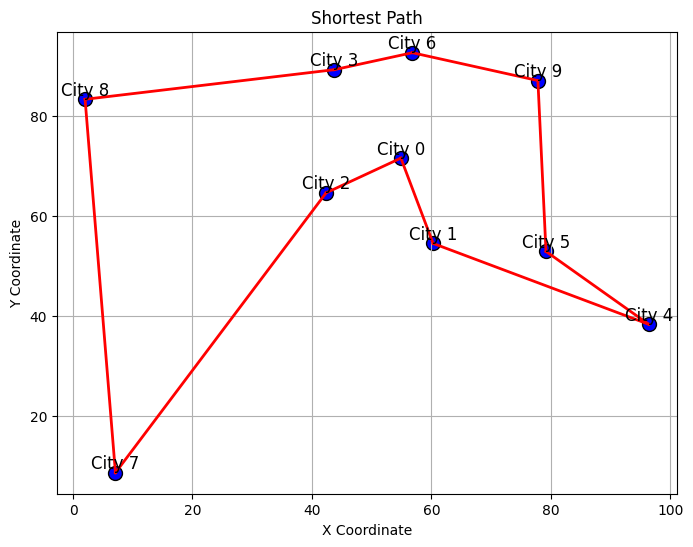

In [ ]:
# Tạo ma trận khoảng cách, tên thành phố và tọa độ ngẫu nhiên cho các thành phố
distances, city_names, cities = generate_random_cities(10)

# Khởi tạo và chạy thuật toán kiến
start_time = time.time()
ant_colony = AntColony(distances, city_names, n_ants=30, n_best=1, n_iterations=50, decay=0.1, alpha=1, beta=5)
shortest_path = ant_colony.run()
end_time = time.time()

print("Shortest path: ", shortest_path[0])
print("Best distance: ", shortest_path[1])

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
# Hiển thị đường đi ngắn nhất
plt.figure(figsize=(8, 6))
plt.scatter(cities[:,0], cities[:,1], c='blue', edgecolors='black', s=100)
for i, city in enumerate(city_names):
    plt.text(cities[i,0], cities[i,1], city, fontsize=12, ha='center', va='bottom')

# Vẽ đường đi ngắn nhất
path_indices = [move[0] for move in shortest_path[0]]
path_indices.append(shortest_path[0][-1][1])
for i in range(len(path_indices) - 1):
    start_city = path_indices[i]
    end_city = path_indices[i + 1]
    start_coords = cities[start_city]
    end_coords = cities[end_city]
    plt.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], color='red', linewidth=2)

plt.title('Shortest Path')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [3]:
def run_ant_colony_experiment(n_ants_options, n_best_options, n_iterations_options, decay_options, alpha_options, beta_options, n_cities=10):
    results = []
    distances, city_names, cities = generate_random_cities(n_cities)

    for n_ants in n_ants_options:
        for n_best in n_best_options:
            for n_iterations in n_iterations_options:
                for decay in decay_options:
                    for alpha in alpha_options:
                        for beta in beta_options:
                            ant_colony = AntColony(distances, city_names, n_ants, n_best, n_iterations, decay, alpha, beta)
                            shortest_path = ant_colony.run()
                            results.append((n_ants, n_best, n_iterations, decay, alpha, beta, shortest_path[1]))
    return results
n_ants_options = [20, 40, 60]
n_best_options = [1, 3, 5]
n_iterations_options = [50, 100, 150]
decay_options = [0.1, 0.2, 0.3]
alpha_options = [1, 2, 3]
beta_options = [2, 5, 8]


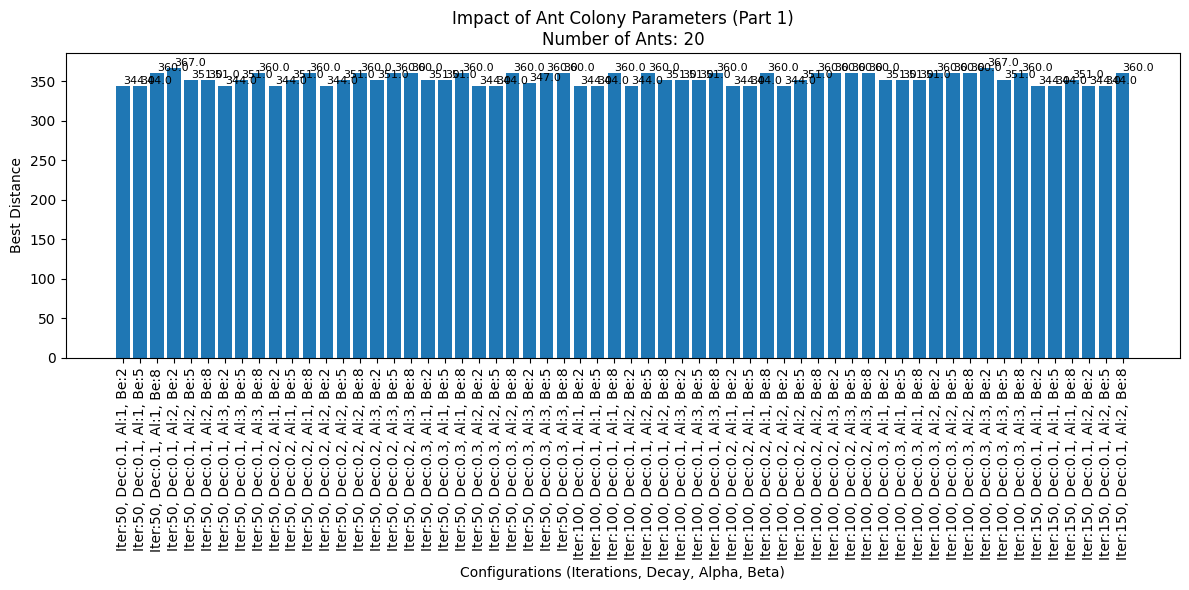

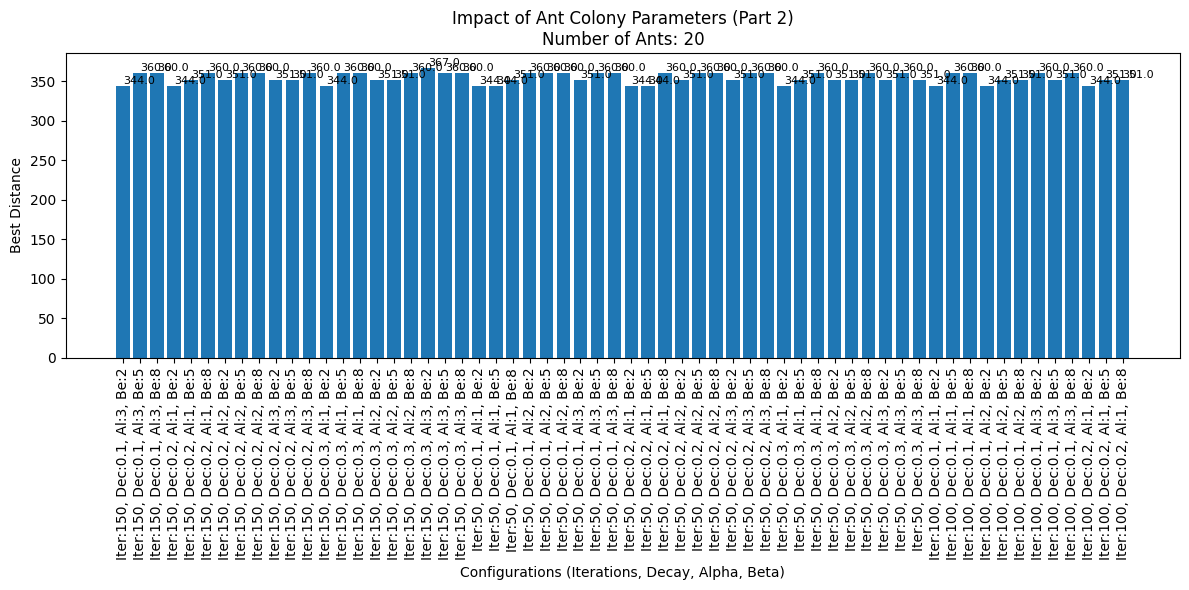

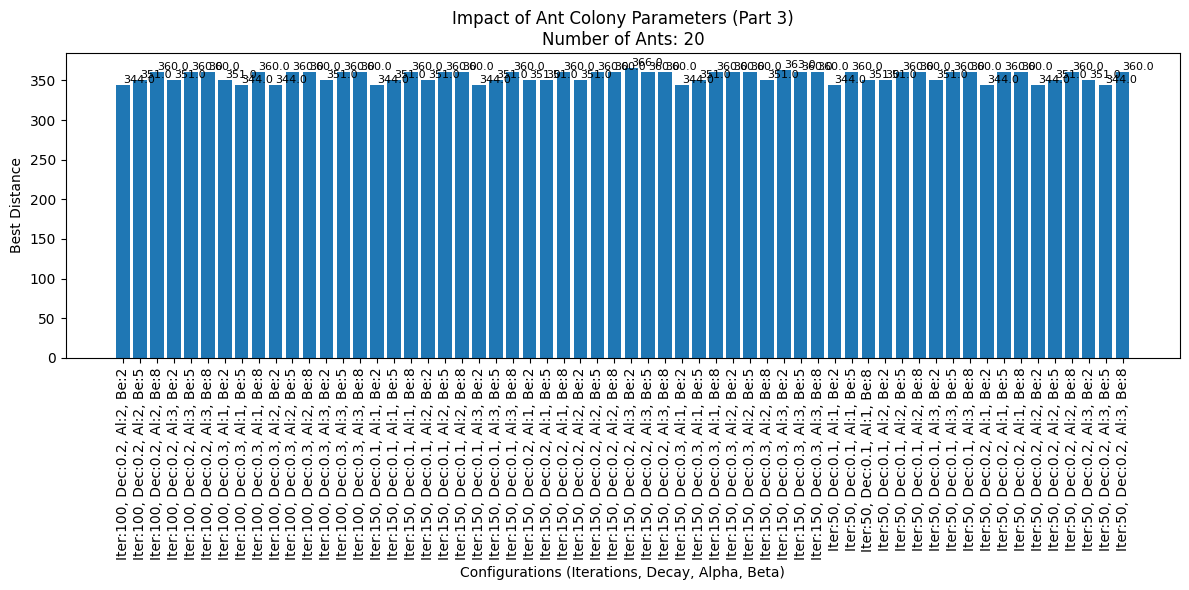

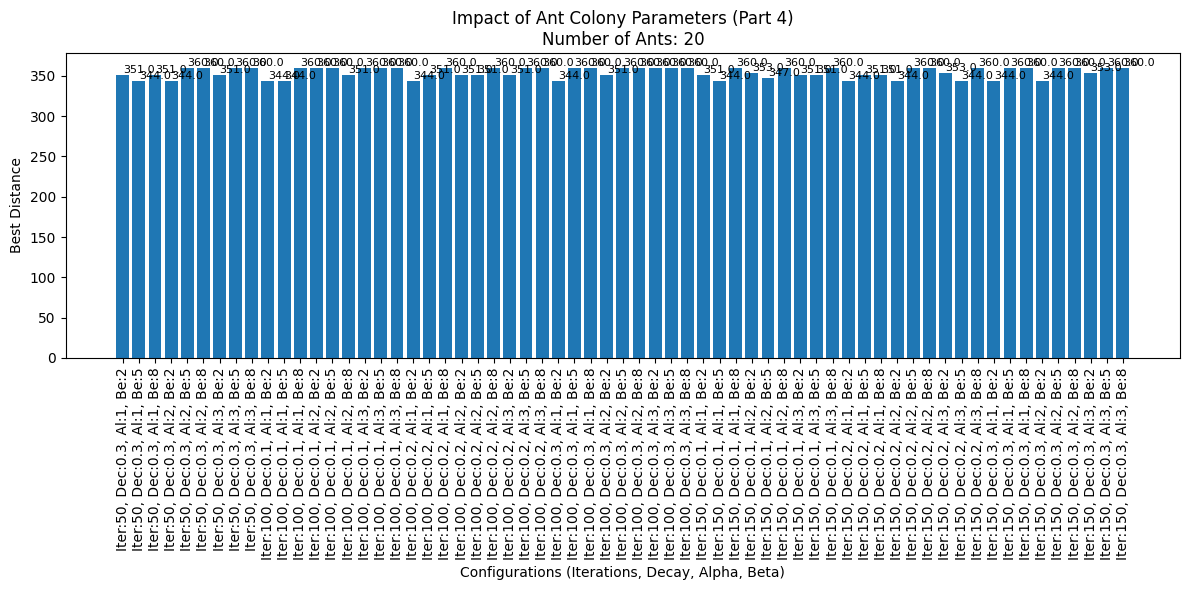

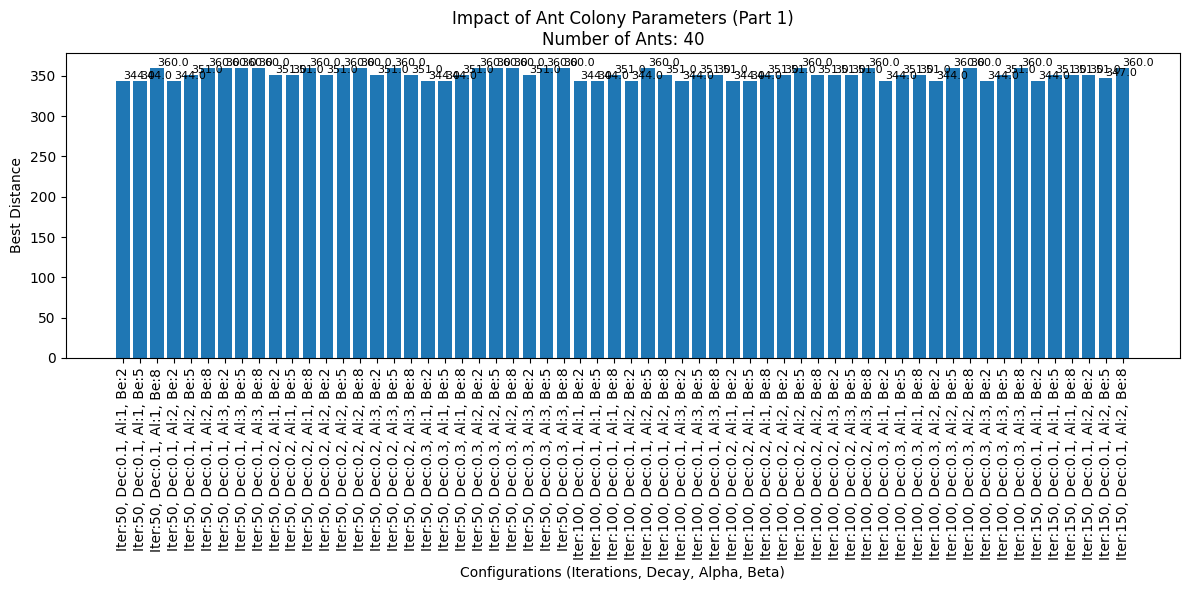

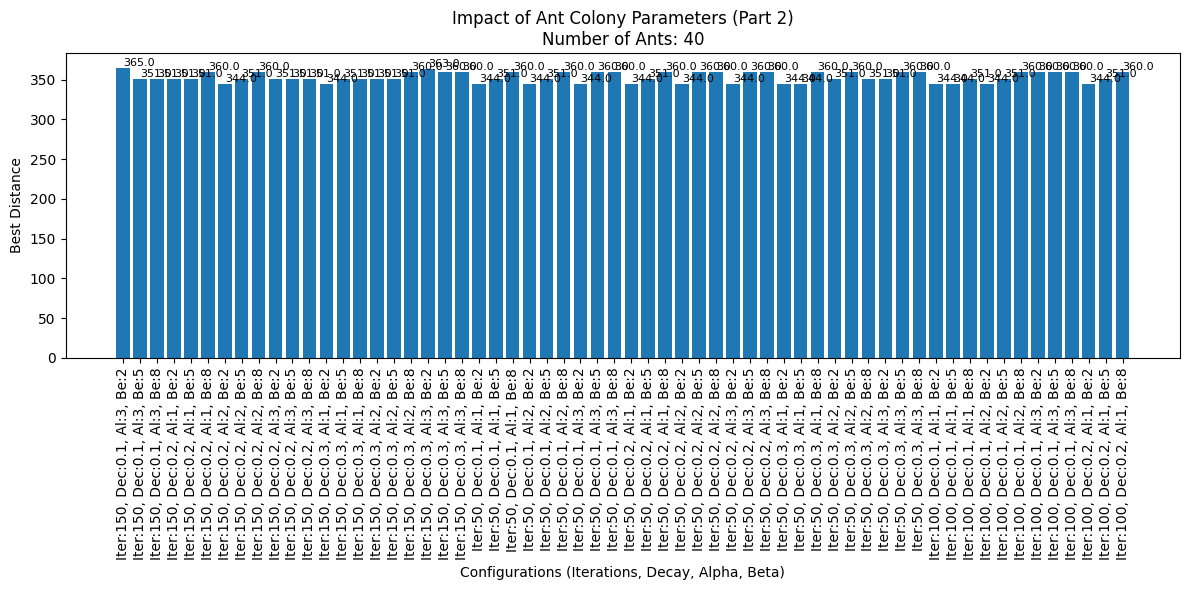

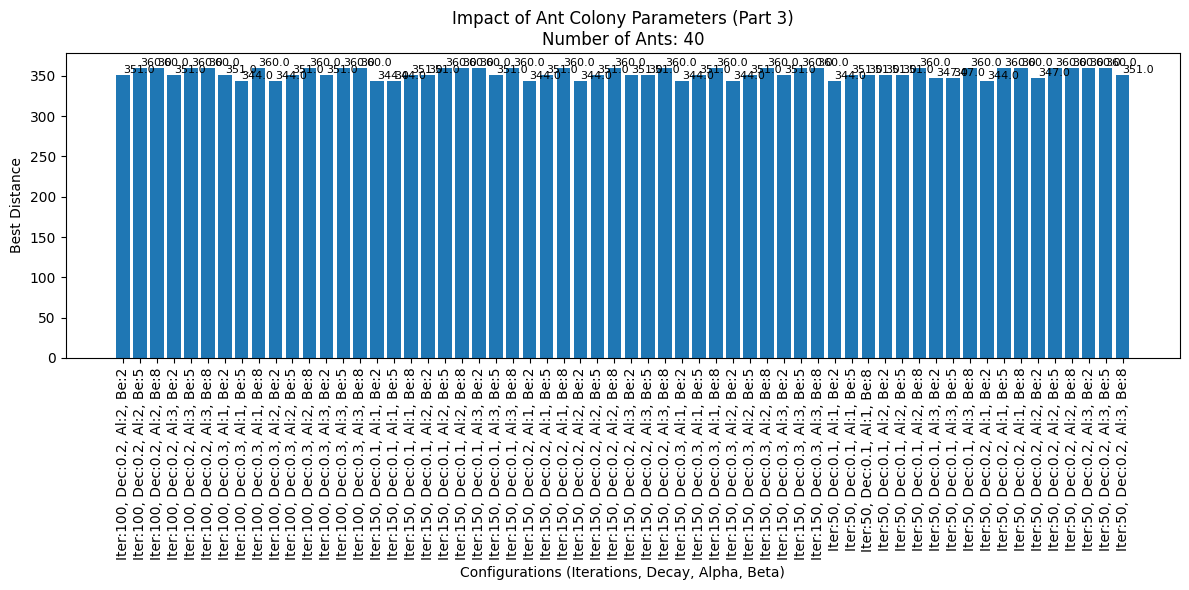

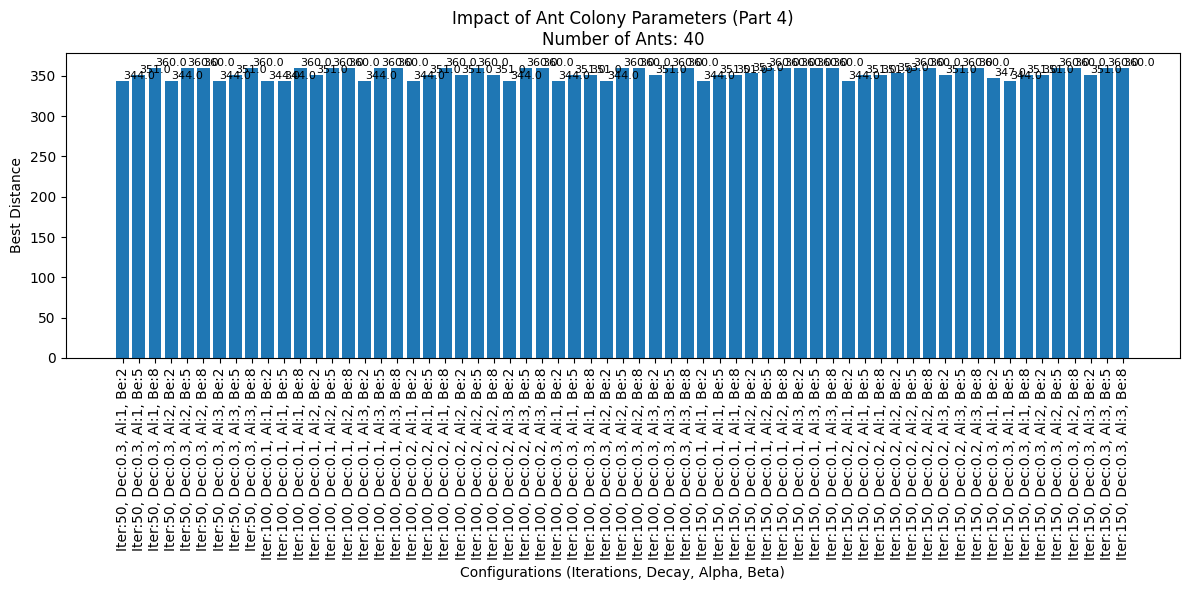

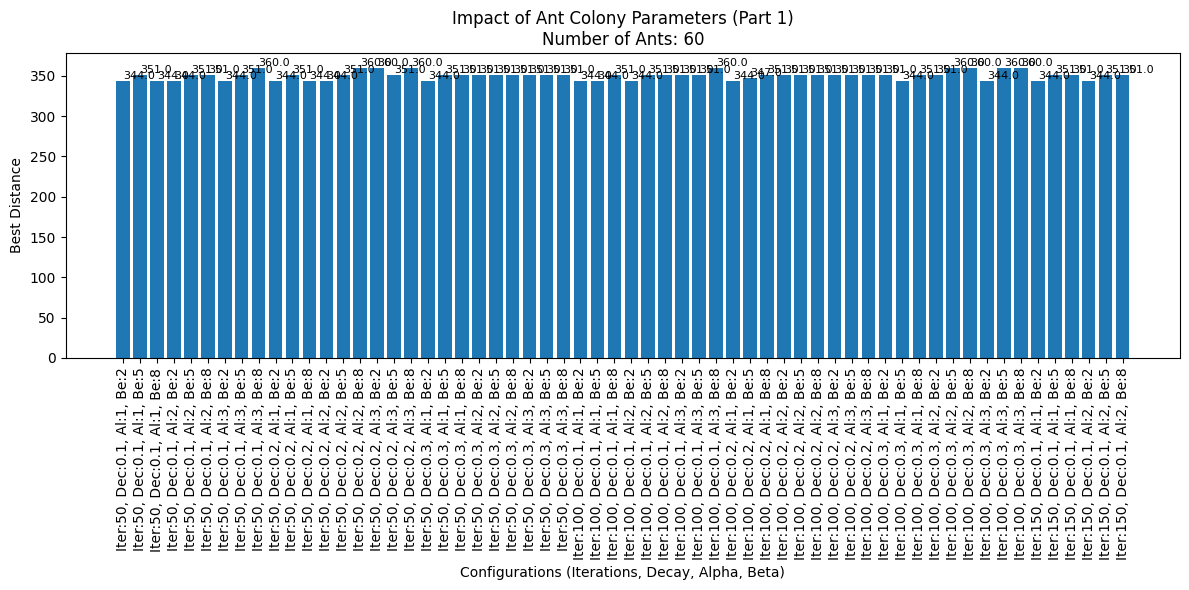

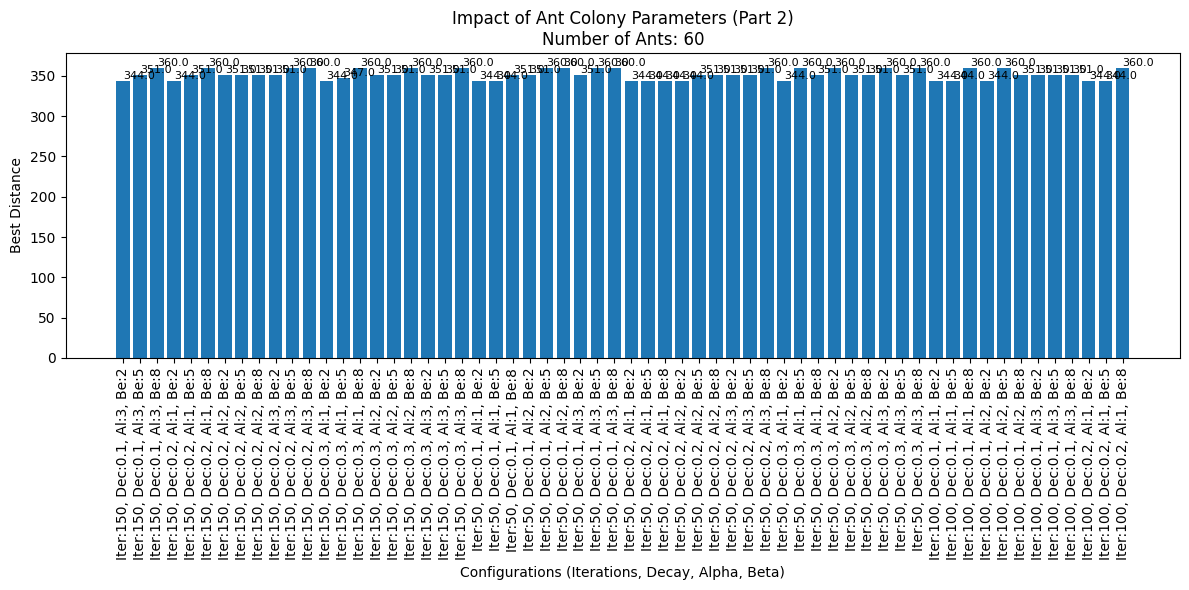

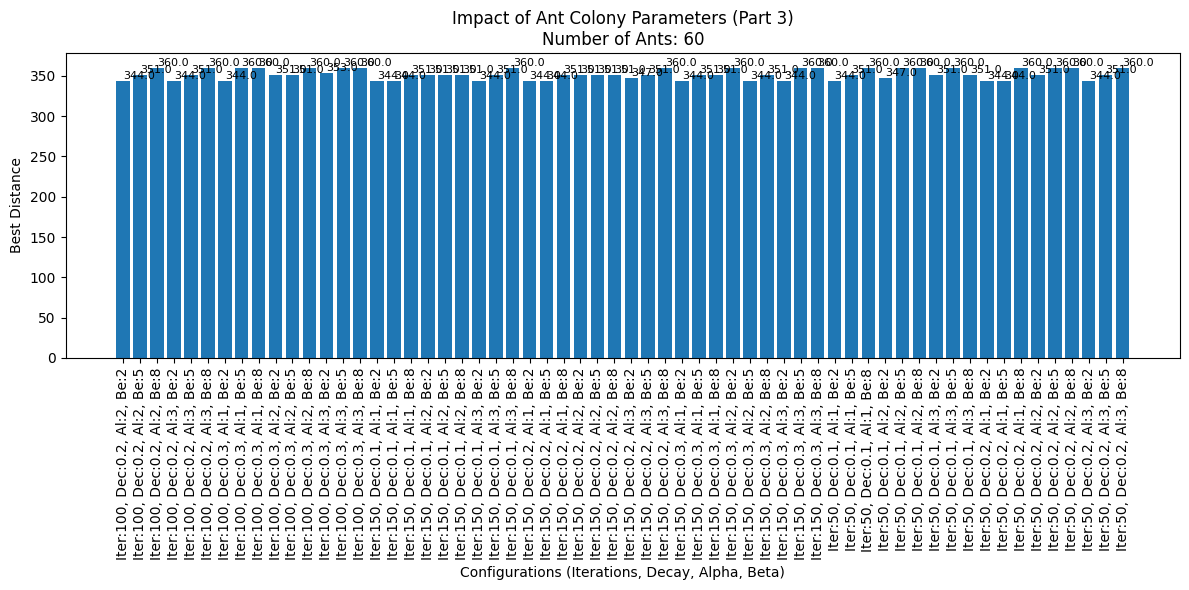

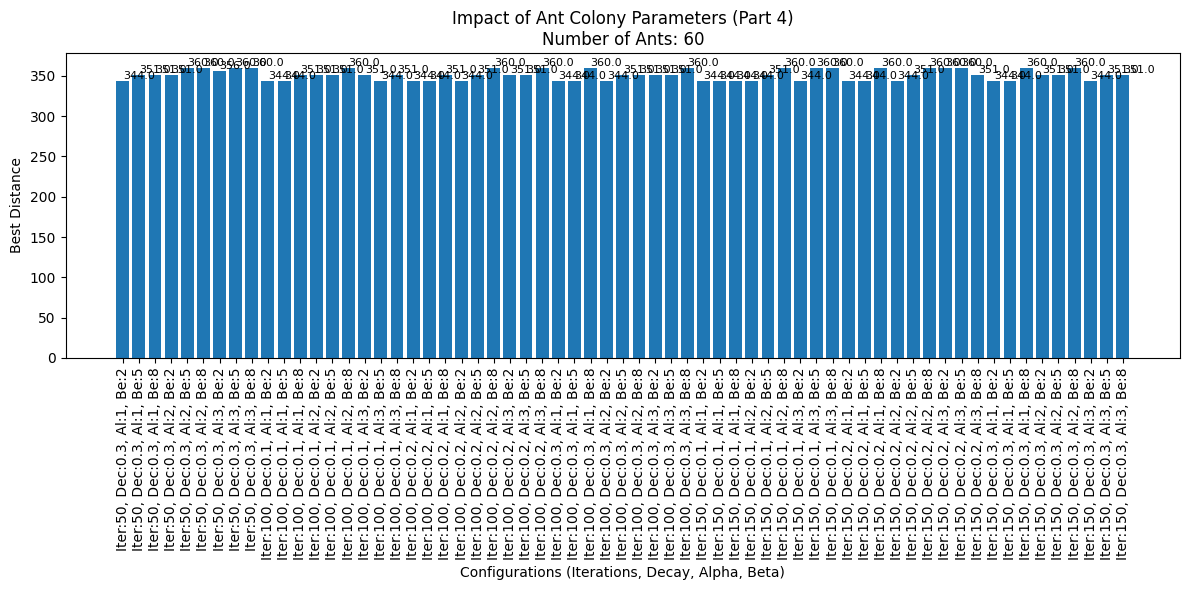

In [4]:
import matplotlib.pyplot as plt

# Chạy thử nghiệm và lấy kết quả
results = run_ant_colony_experiment(n_ants_options, n_best_options, n_iterations_options, decay_options, alpha_options, beta_options)

# Biểu đồ thay đổi của kết quả tối ưu
for n_ants in n_ants_options:
    filtered_results = [result for result in results if result[0] == n_ants]
    quarter = len(filtered_results) // 4  # Tìm chỉ số để chia tư kết quả

    for i in range(4):  # Tạo một biểu đồ cho mỗi phần tư
        start_index = i * quarter
        end_index = start_index + quarter if i < 3 else len(filtered_results)  # Đảm bảo phần cuối cùng bao gồm tất cả các mục còn lại

        part_distances = [result[-1] for result in filtered_results[start_index:end_index]]
        part_labels = [f"Iter:{result[2]}, Dec:{result[3]}, Al:{result[4]}, Be:{result[5]}" for result in filtered_results[start_index:end_index]]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(part_labels, part_distances)
        plt.xlabel('Configurations (Iterations, Decay, Alpha, Beta)')
        plt.ylabel('Best Distance')
        plt.title(f'Impact of Ant Colony Parameters (Part {i+1})\nNumber of Ants: {n_ants}')
        plt.xticks(rotation=90)

        # Thêm nhãn trên mỗi cột
        for bar in bars:
            yval = bar.get_height()
            # Căn chỉnh vị trí nhãn ở phía trên mỗi cột và điều chỉnh kích thước font chữ
            plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', fontsize=8)  # Giảm fontsize xuống còn 8

        plt.tight_layout()
        plt.show()


In [ ]:
def measure_performance(city_counts, n_ants=30, n_best=10, n_iterations=100, decay=0.1, alpha=1, beta=2):
    times = []
    best_distances = []
    for n_cities in city_counts:
        # Sinh ngẫu nhiên các thành phố và khoảng cách giữa chúng
        distances, city_names, cities = generate_random_cities(n_cities)

        # Khởi tạo đối tượng AntColony
        ant_colony = AntColony(distances, city_names, n_ants, n_best, n_iterations, decay, alpha, beta)

        # Bắt đầu đo thời gian
        start_time = time.time()

        # Chạy thuật toán
        best_path, best_path_distance = ant_colony.run()

        # Kết thúc đo thời gian
        end_time = time.time()

        # Tính thời gian thực thi
        execution_time = end_time - start_time
        times.append(execution_time)
        best_distances.append(best_path_distance)

    return times, best_distances


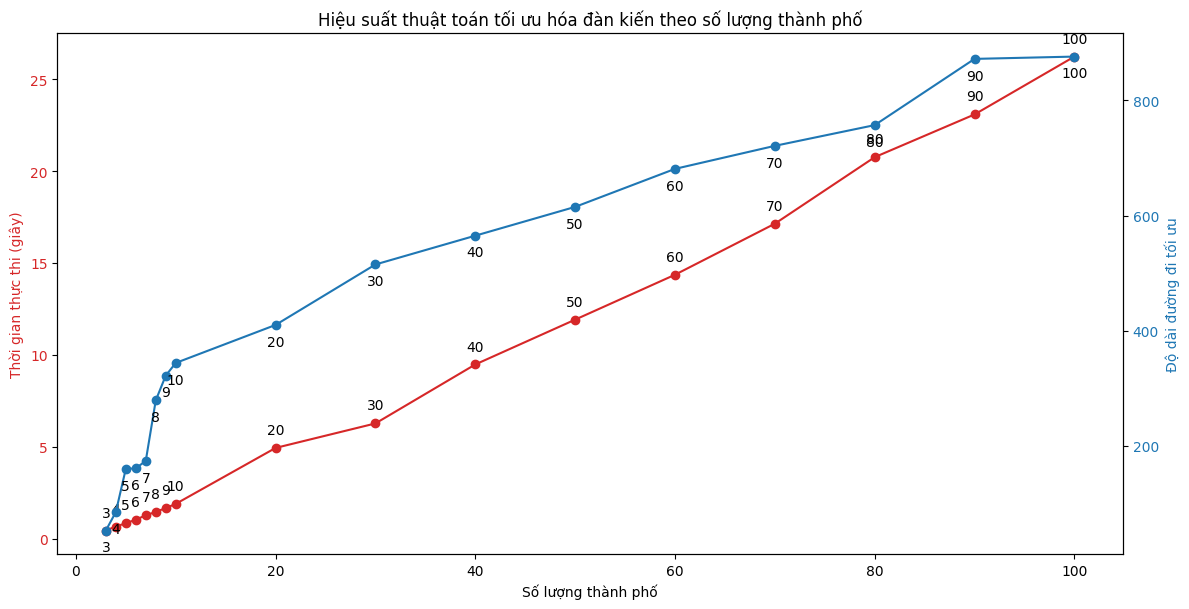

In [ ]:
city_counts = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Giảm số lượng thành phố nếu thuật toán chạy quá chậm
execution_times, best_distances = measure_performance(city_counts)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Số lượng thành phố')
ax1.set_ylabel('Thời gian thực thi (giây)', color=color)
ax1.plot(city_counts, execution_times, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Thêm nhãn cho mỗi điểm trên biểu đồ thời gian thực thi
for i, txt in enumerate(city_counts):
    ax1.annotate(f'{txt}', (city_counts[i], execution_times[i]), textcoords="offset points", xytext=(0,10), ha='center')

ax2 = ax1.twinx()  # Trục y mới chia sẻ cùng trục x
color = 'tab:blue'
ax2.set_ylabel('Độ dài đường đi tối ưu', color=color)
ax2.plot(city_counts, best_distances, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Thêm nhãn cho mỗi điểm trên biểu đồ độ dài đường đi
for i, txt in enumerate(city_counts):
    ax2.annotate(f'{txt}', (city_counts[i], best_distances[i]), textcoords="offset points", xytext=(0,-15), ha='center')

fig.tight_layout()
plt.title('Hiệu suất thuật toán tối ưu hóa đàn kiến theo số lượng thành phố')
plt.show()
